# Annual income prediction using the adult dataset

## EDA

Inspect data
'fnlwgt' is 'final person weight' from Census microdata, don't use it as a feature

In [46]:
from sklearn.datasets import fetch_openml

adult = fetch_openml("adult", version=2, as_frame=True)  # pulls from OpenML
df_inspect = adult.frame.copy()  # features + target in one DataFrame
a = adult.data
b = adult.target  # '>50K' / '<=50K'

a.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States




*   Load dataset from OpenLM into pandas as DataFrame
Creates a binary target (1 >= $50k, 0 < $50k)
*   Convert fnlwgt to the sample weight since it indicates how many people this row represents in the population - it's a survery artefact and not a personal feature. We keep it as sample_weight in case we want to run a weighted sensitivity analysis
*   Adding two columns, 'has_capital_gain' and 'has_capital_loss' as data is very skewed - few big values and moslty 0s. Flag captures presence of gains and losses representing different socioeconomic groups. Later log-transform capital gains and capital losses to measure magnitudes





In [47]:
# Import Data

from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np

# Load from OpenML (already clean; 'class' is the label)
adult = fetch_openml("adult", version=2, as_frame=True)
df = adult.frame.copy()

# Target: 1 for >50K, 0 for <=50K
df["target"] = (df["class"] == ">50K").astype(int)

# Optional: quick engineered flags (deterministic, no leakage)
df["has_capital_gain"] = (df["capital-gain"] > 0).astype(int)
df["has_capital_loss"] = (df["capital-loss"] > 0).astype(int)

# We'll keep fnlwgt as a sample weight, not a predictive feature
sample_weight = df["fnlwgt"].astype(float).values

df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class,target,has_capital_gain,has_capital_loss
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K,0,0,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K,0,0,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K,1,0,0
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K,1,1,0
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K,0,0,0


24% positive, and 76% negative, so moderate class imbalance. Stratify splits to keep class proportions.
Use PR-AUC (Area Under the Precision Recall Curve) as the primary metric focusing on false positives and minority class performance.
Accuracy is misleading with one dominating class.
Use class_weights='balanced' to treat mistakes on the minority class as more costly


In [48]:
# Check class balance
df["target"].value_counts(normalize = True)

,proportion
target,
0,0.760718
1,0.239282


In [49]:
# Check missing values
df.isna().sum().sort_values(ascending=False).head(10)

,0
occupation,2809
workclass,2799
native-country,857
age,0
education-num,0
fnlwgt,0
marital-status,0
relationship,0
race,0
education,0


In [50]:
# peak at datatypes
df.dtypes

,0
age,int64
workclass,category
fnlwgt,int64
education,category
education-num,int64
marital-status,category
occupation,category
relationship,category
race,category
sex,category


In [51]:
# Because dtype is 'category', add an explicit 'Unknown' for NaNs just for EDA
country_all = df["native-country"].cat.add_categories(["Unknown"]).fillna("Unknown")

# Top countries by count and proportion
overall_counts = country_all.value_counts()
overall_props  = country_all.value_counts(normalize=True)

pd.concat([overall_counts.rename("count"),
           overall_props.rename("proportion")], axis=1).head(15)


,count,proportion
native-country,,
United-States,43832,0.897424
Mexico,951,0.019471
Unknown,857,0.017546
Philippines,295,0.006040
Germany,206,0.004218
Puerto-Rico,184,0.003767
Canada,182,0.003726
El-Salvador,155,0.003173
India,151,0.003092


# Preprocessing steps discussed as a team

In [52]:
import numpy as np
import pandas as pd

# Check missing values
df.isna().sum().sort_values(ascending=False).head(10)

# Columns with NaN values
na_cols = ["workclass", "occupation", "native-country"]

# Copy of original for comparison
df_orig = df.copy()

# Drop NaNs
df_clean = df.dropna(subset=na_cols).copy()

# Number of missing values
print("Missing values:", df.shape[0] - df_clean.shape[0])

before, after = len(df), len(df_clean)
print(f"Rows before: {len(df_orig):,} | after drop: {len(df_clean):,} | removed: {len(df_orig)-len(df_clean):,}"
      f"({(len(df_orig)-len(df_clean))/len(df_orig):.2%})")

# Class prvalence before vs after (unweighted)
prev_before = df_orig["target"].mean()
prev_after = df_clean["target"].mean()
print(f"Prevalence y=1 before: {prev_before:.3f} | after: {prev_after:.3f}")

df_clean.head()

Missing values: 3620
Rows before: 48,842 | after drop: 45,222 | removed: 3,620(7.41%)
Prevalence y=1 before: 0.239 | after: 0.248


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class,target,has_capital_gain,has_capital_loss
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K,0,0,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K,0,0,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K,1,0,0
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K,1,1,0
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K,0,0,0


In [53]:
# Log transformation of columns
cols_to_log = ["capital-gain", "capital-loss"]
df_clean[cols_to_log] = df_clean[cols_to_log].apply(np.log1p)

In [54]:
from sklearn.preprocessing import LabelEncoder
label_encoders = {}  # Store encoders for decoding later
categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns

# df_clean.columns
for column in categorical_cols:
    le = LabelEncoder()
    df_clean[column] = le.fit_transform(df_clean[column])  # Convert categorical values to numbers
    label_encoders[column] = le  # Store encoders for later decoding

    # Print the mapping of categorical values to numbers
    print(f"Mapping for '{column}':")
    print(dict(zip(le.classes_, le.transform(le.classes_))))  # Shows the mapping in alphabetical order
    print() # Empty line for better readability


Mapping for 'workclass':
{'Federal-gov': np.int64(0), 'Local-gov': np.int64(1), 'Private': np.int64(2), 'Self-emp-inc': np.int64(3), 'Self-emp-not-inc': np.int64(4), 'State-gov': np.int64(5), 'Without-pay': np.int64(6)}

Mapping for 'education':
{'10th': np.int64(0), '11th': np.int64(1), '12th': np.int64(2), '1st-4th': np.int64(3), '5th-6th': np.int64(4), '7th-8th': np.int64(5), '9th': np.int64(6), 'Assoc-acdm': np.int64(7), 'Assoc-voc': np.int64(8), 'Bachelors': np.int64(9), 'Doctorate': np.int64(10), 'HS-grad': np.int64(11), 'Masters': np.int64(12), 'Preschool': np.int64(13), 'Prof-school': np.int64(14), 'Some-college': np.int64(15)}

Mapping for 'marital-status':
{'Divorced': np.int64(0), 'Married-AF-spouse': np.int64(1), 'Married-civ-spouse': np.int64(2), 'Married-spouse-absent': np.int64(3), 'Never-married': np.int64(4), 'Separated': np.int64(5), 'Widowed': np.int64(6)}

Mapping for 'occupation':
{'Adm-clerical': np.int64(0), 'Armed-Forces': np.int64(1), 'Craft-repair': np.int64(2

Information Ranking on Information Gain

Mutual Information Scores for Features:
             Feature  MI Score
6       relationship  0.118259
4     marital-status  0.112149
9       capital-gain  0.082715
0                age  0.066988
2          education  0.064959
5         occupation  0.062541
3      education-num  0.062430
11    hours-per-week  0.038687
10      capital-loss  0.036247
13  has_capital_gain  0.033424
8                sex  0.033392
1          workclass  0.019459
7               race  0.014916
12    native-country  0.009889
14  has_capital_loss  0.008629


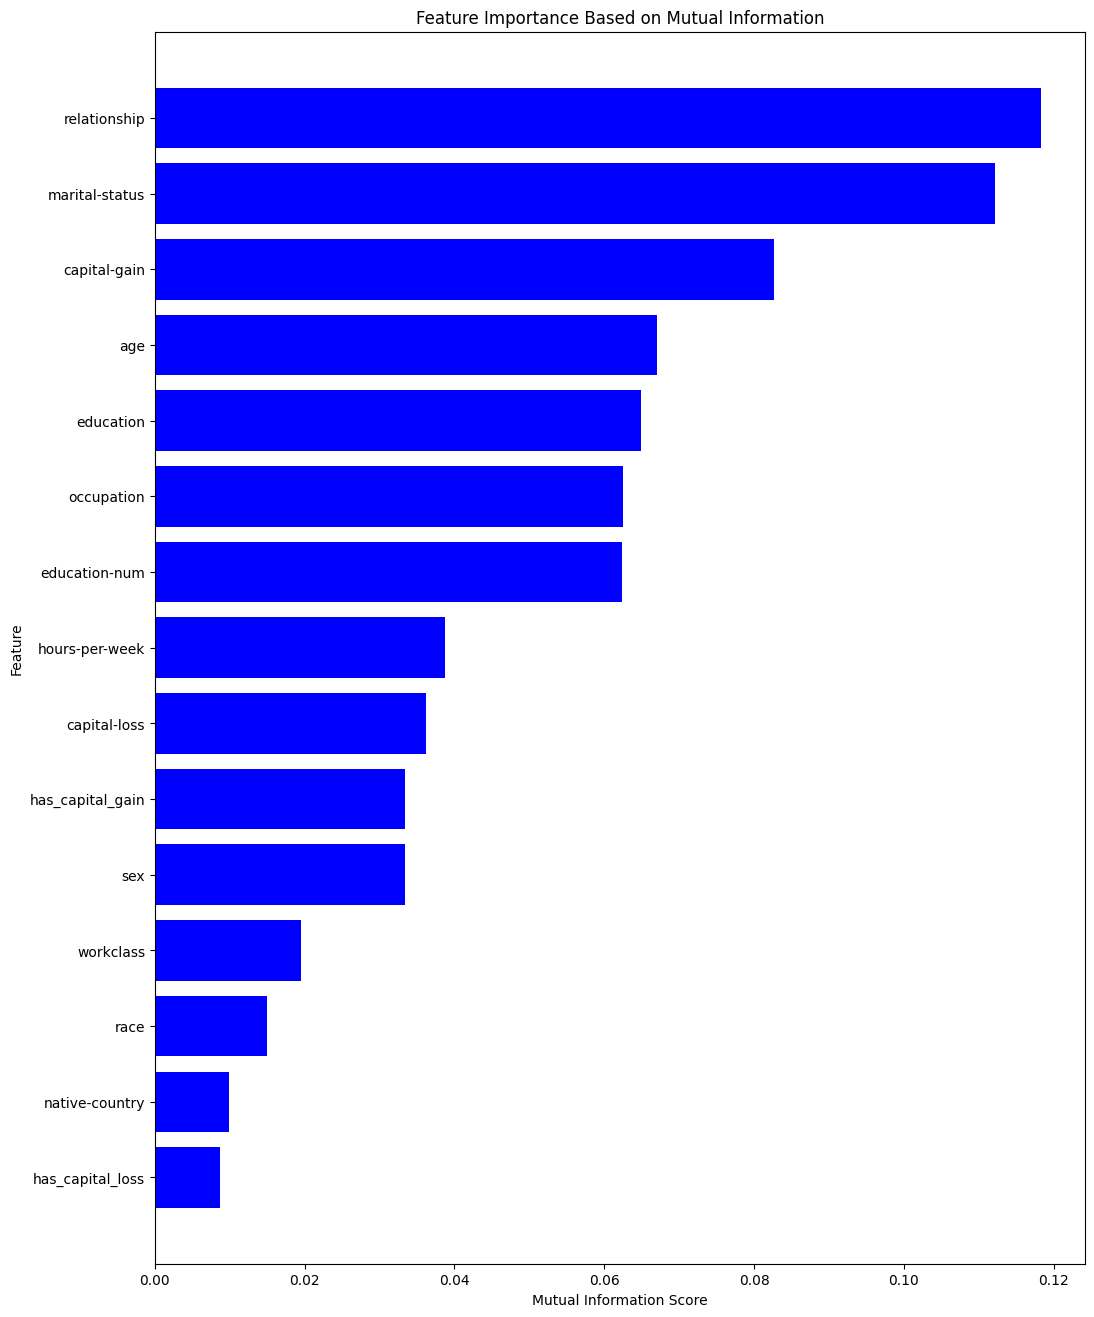

In [55]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

# Mutual information ranking of features
feature_cols = [c for c in df_clean.columns if c not in ["class", "target", "fnlwgt"]]
X = df_clean[feature_cols]
y = df_clean["target"].values
mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=42)

# Convert MI scores into a DataFrame for easier visualization
mi_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})

# Sort the features by their MI scores in descending order (highest importance first)
mi_df = mi_df.sort_values(by='MI Score', ascending=False)

print("Mutual Information Scores for Features:")
print(mi_df)  # Print the MI scores for each feature

plt.figure(figsize=(12, 16))
plt.barh(mi_df['Feature'], mi_df['MI Score'], color='blue')  # Plot bars

# Add labels and title for better understanding
plt.xlabel("Mutual Information Score")  # Label for x-axis
plt.ylabel("Feature")  # Label for y-axis
plt.title("Feature Importance Based on Mutual Information")  # Chart title

# Invert y-axis so that the most important feature is at the top
plt.gca().invert_yaxis()

# Show the plot
plt.show()

In [56]:
# statistical analysis - ANOVA Table
from sklearn.feature_selection import f_classif
F_values, p_values = f_classif(X, y)
anova_df = pd.DataFrame({
    "Feature": X.columns,
    "F-value": F_values,
    "p-value": p_values
}).sort_values(by="F-value", ascending=False)

print(anova_df.head(15))

             Feature      F-value        p-value
3      education-num  5632.170804   0.000000e+00
9       capital-gain  4081.905156   0.000000e+00
13  has_capital_gain  3425.223094   0.000000e+00
6       relationship  3102.946175   0.000000e+00
0                age  2692.087895   0.000000e+00
11    hours-per-week  2461.281534   0.000000e+00
8                sex  2207.890435   0.000000e+00
4     marital-status  1744.123164   0.000000e+00
10      capital-loss   894.224165  1.401734e-194
14  has_capital_loss   863.891638  4.121209e-188
2          education   300.107490   5.141391e-67
7               race   228.098747   2.068118e-51
5         occupation   112.369235   3.183964e-26
12    native-country    18.281482   1.909407e-05
1          workclass    11.091075   8.681355e-04


Team has decided to eliminate all features with less than 0.02 of Information Gain score

In [57]:
processed_feature_cols = [c for c in df_clean.columns if c not in ["class", "target", "fnlwgt","has_capital_loss","native-country","race","workclass"]]
X = df_clean[processed_feature_cols]
y = df_clean["target"].values

Split training/validation/test data

In [58]:
from sklearn.model_selection import train_test_split
import pandas as pd


# 3) First split: train vs temp (80% / 20%), stratified by label
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# 4) Second split: val vs test (50% / 50%), stratified again
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# 5) Class balance in each split
def describe_split(name, y_arr):
    counts = pd.Series(y_arr).value_counts(normalize=True).sort_index()
    print(f"{name:>6s} | n={len(y_arr):5d} | P(y=1)={counts.get(1,0):.3f} | P(y=0)={counts.get(0,0):.3f}")

describe_split("train", y_train)
describe_split("  val", y_val)
describe_split(" test", y_test)

# Baseline PR-AUC you should beat ~ prevalence
prevalence = y.mean()
print(f"\nBaseline PR-AUC (≈ prevalence): {prevalence:.3f}")

 train | n=36177 | P(y=1)=0.248 | P(y=0)=0.752
   val | n= 4522 | P(y=1)=0.248 | P(y=0)=0.752
  test | n= 4523 | P(y=1)=0.248 | P(y=0)=0.752

Baseline PR-AUC (≈ prevalence): 0.248


In [59]:
final_results = []  # List to store all model performance results

Logistic Regression

C=0.01  mean F1=0.61252
C=0.1   mean F1=0.61199
C=0.5   mean F1=0.61210
C=1     mean F1=0.61195
C=5     mean F1=0.61192
C=10    mean F1=0.61198
Tuned Best C by 5-fold CV (F1): 0.01


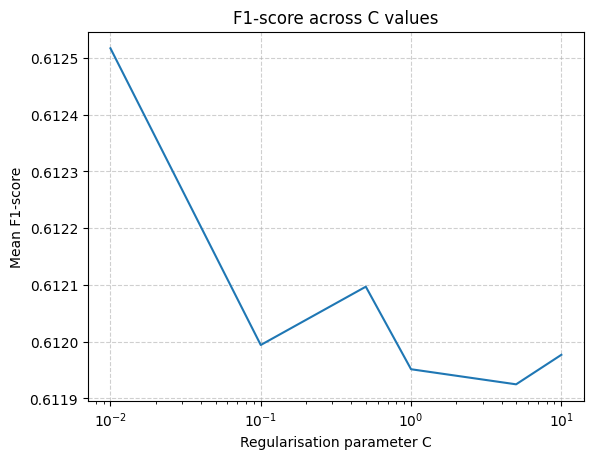

Best F1 on val = 0.60642 @ threshold=-0.07507

Test set result
              precision    recall  f1-score   support

           0    0.90767   0.73398   0.81164      3402
           1    0.48928   0.77342   0.59938      1121

    accuracy                        0.74375      4523
   macro avg    0.69847   0.75370   0.70551      4523
weighted avg    0.80397   0.74375   0.75903      4523



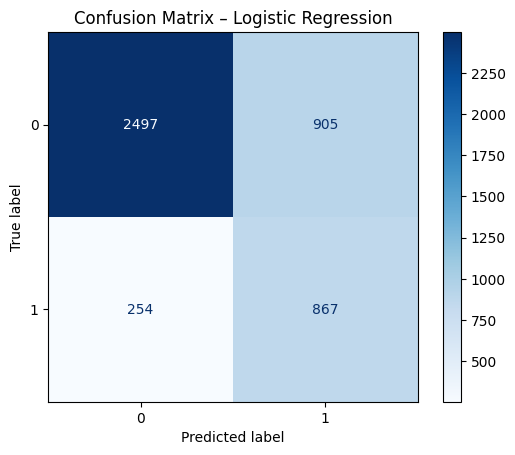

In [60]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt


# Drop "has_capital_gain"
X_train = X_train.drop(columns=['has_capital_gain'], errors='ignore').copy()
X_val  = X_val.drop(columns=['has_capital_gain'],   errors='ignore').copy()
X_test = X_test.drop(columns=['has_capital_gain'],  errors='ignore').copy()


# Parameter tuning, using F1
C_value = [0.01, 0.1, 0.5, 1, 5, 10]
cv_means = []
for C in C_value:
    cv_model = LogisticRegression(max_iter=2000, C=C, class_weight="balanced", random_state=42)
    scores = cross_val_score(cv_model, X_train, y_train, cv=5, scoring="f1")
    cv_means.append(scores.mean())
    print(f"C={C:<5} mean F1={scores.mean():.5f}")
best_C = C_value[int(np.argmax(cv_means))]
print(f"Tuned Best C by 5-fold CV (F1): {best_C}")

plt.figure()
plt.plot(C_value, cv_means)
plt.xscale('log')
plt.xlabel('Regularisation parameter C')
plt.ylabel('Mean F1-score')
plt.title('F1-score across C values')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

model = LogisticRegression(max_iter=2000, C=best_C, class_weight="balanced", random_state=42)
model.fit(X_train, y_train)

# Threshold tuning, using F1
val_score = model.decision_function(X_val)
prec, rec, thr = precision_recall_curve(y_val, val_score)
f1 = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1)
best_thr = thr[best_idx-1] if best_idx>0 else 0.5
print(f"Best F1 on val = {f1[best_idx]:.5f} @ threshold={best_thr:.5f}")

# Test set results
test_score = model.decision_function(X_test)
y_pred = (test_score >= best_thr).astype(int)

print("\nTest set result")
print(classification_report(y_test, y_pred, digits=5))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(values_format="d", cmap="Blues")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()



In [64]:
# Logistic Regression coefficients display
import numpy as np
import pandas as pd
from IPython.display import display

coefs = np.ravel(model.coef_)
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

print("\nTop 10 feature coefficients")
display(coef_df.head(10))


Top 10 feature coefficients


,feature,coef,abs_coef
6,sex,0.808062,0.808062
2,education-num,0.335886,0.335886
3,marital-status,-0.257892,0.257892
7,capital-gain,0.203652,0.203652
8,capital-loss,0.160920,0.160920
5,relationship,-0.108717,0.108717
0,age,0.040028,0.040028
9,hours-per-week,0.032897,0.032897
1,education,0.016010,0.016010
4,occupation,-0.000210,0.000210


PR-AUC: 0.649


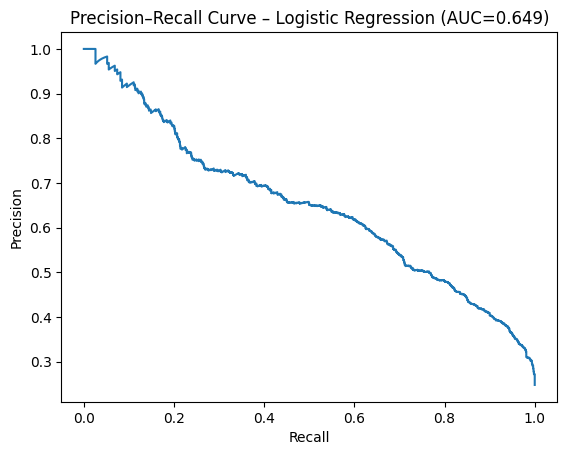


 Conclusion: Precision=0.49 | Recall=0.77 | Accuracy=0.74


In [65]:
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score, accuracy_score

y_score = model.decision_function(X_test)
y_pred = (y_score >= best_thr).astype(int)

prec, rec, thr = precision_recall_curve(y_test, y_score)
pr_auc = auc(rec, prec)
print(f"PR-AUC: {pr_auc:.3f}")
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve – Logistic Regression (AUC={pr_auc:.3f})")
plt.show()

# Logistic Regression Conclusion
p = precision_score(y_test, y_pred)
r = recall_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(f"\n Conclusion: Precision={p:.2f} | Recall={r:.2f} | Accuracy={acc:.2f}")

# add results to all models summary table
final_results.append({"Model": "Logistic Regression", "Accuracy": round(acc,2), "Precision": round(p,2), "Recall": round(r,2)})

Decision Tree Model

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model Comparison Results:
 Depth of Tree  Accuracy  Precision  Recall
             1  0.752101       0.38    0.50
             2  0.818885       0.78    0.69
             3  0.828616       0.79    0.71
             4  0.833702       0.79    0.73
             5  0.843653       0.81    0.74
             6  0.844096       0.81    0.74
             7  0.847855       0.82    0.75
             8  0.848297       0.82    0.75
             9  0.852499       0.82    0.76
            10  0.849182       0.82    0.76
            11  0.852057       0.82    0.76


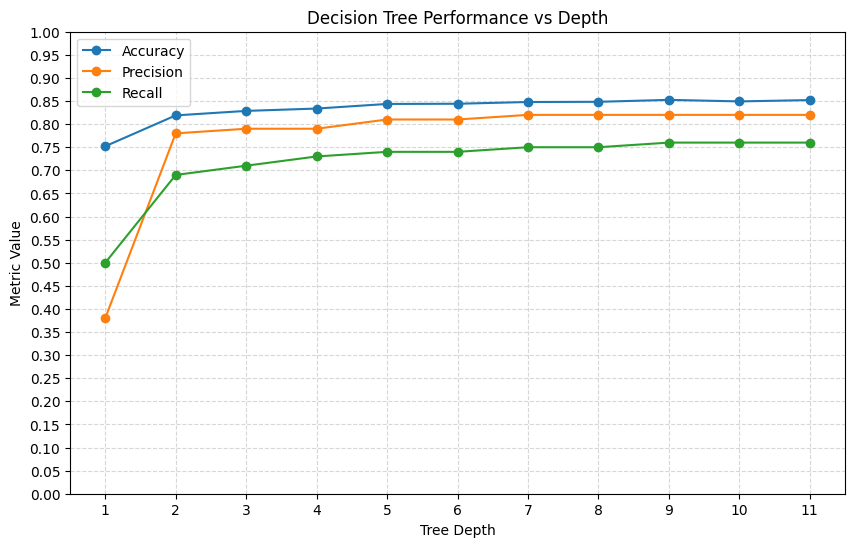

In [61]:
# Decision Tree Model Parameter Tuning (Depth of Tree)
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score
from matplotlib.ticker import MultipleLocator

# Tune tree depth - small tree High Bias, Low Variance, big tree Low Bias, High Variance
depth = range(1,12)
conf_matrices = {}
results = []

# Parameter Tuning
for d in depth:
  dt = DecisionTreeClassifier(criterion="entropy", max_depth=d, random_state=42)
  dt.fit(X_train, y_train)
  dt_y_pred = dt.predict(X_val)
  dt_cm = confusion_matrix(y_val, dt_y_pred)
  conf_matrices[d] = dt_cm

  acc = accuracy_score(y_val, dt_y_pred)  # Overall accuracy
  prec = round(precision_score(y_val, dt_y_pred, average='macro'), 2)  # Average precision across classes
  rec = round(recall_score(y_val, dt_y_pred, average='macro'), 2)
  results.append({"Depth of Tree": d, "Accuracy": acc, "Precision": prec, "Recall": rec})


results_df = pd.DataFrame(results)

# Print the performance results of all models
print("Model Comparison Results:")
print(results_df.to_string(index=False))


plt.figure(figsize=(10,6))

# Plot each metric
plt.plot(results_df["Depth of Tree"], results_df["Accuracy"], marker='o', label='Accuracy')
plt.plot(results_df["Depth of Tree"], results_df["Precision"], marker='o', label='Precision')
plt.plot(results_df["Depth of Tree"], results_df["Recall"], marker='o', label='Recall')

# Step size for axis
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.05))

# Labels & title
plt.xlabel("Tree Depth")
plt.ylabel("Metric Value")
plt.title("Decision Tree Performance vs Depth")
plt.xticks(results_df["Depth of Tree"])
plt.ylim(0,1)  # since metrics are 0-1
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [62]:
# check types of each dataframe
print(type(X_train))
print(type(X_val))
print(type(y_train))
print(type(y_val))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


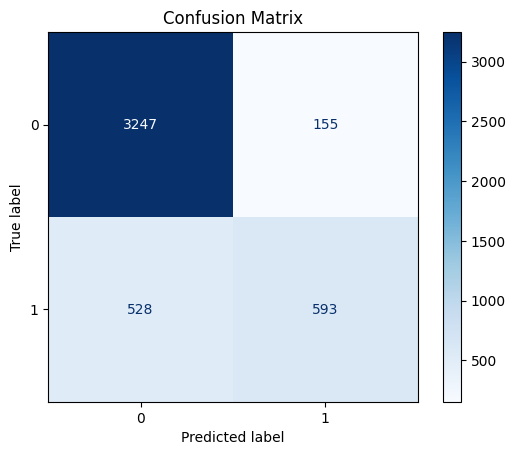


The most important attribute (Root Node) is: relationship

 Accuracy 0.85

 Precision 0.83

 Recall 0.74

 F1-Score 0.63


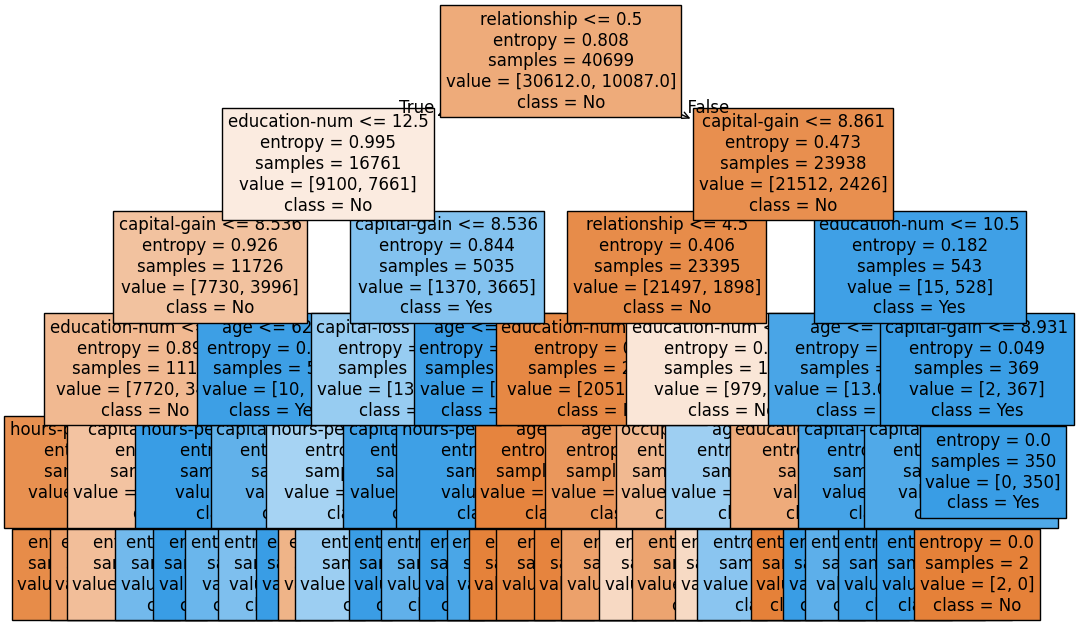

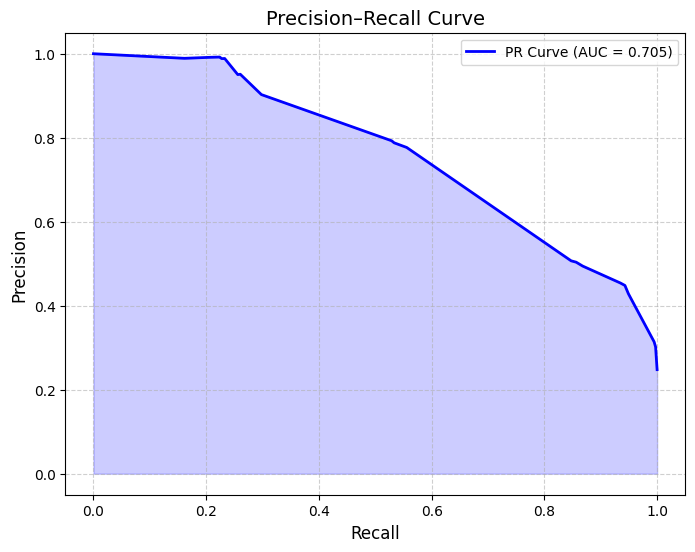

In [63]:
# Final Decision Tree model after parameter tuning - depth 5 chosen
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,precision_recall_curve, average_precision_score, f1_score
import matplotlib.pyplot as plt
dt_model = DecisionTreeClassifier(criterion="entropy", max_depth=5, random_state=42)

# Merge train & validation
X_train_val = pd.concat([X_train, X_val], axis=0, ignore_index=True)
y_train_val = np.concatenate([y_train, y_val], axis=0)

# Final Decision Tree Model
dt_model.fit(X_train_val, y_train_val)

# Prediction of Model
dt_y_pred = dt_model.predict(X_test)

# Confusion Matrix
dt_cm = confusion_matrix(y_test, dt_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=dt_cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Metrics - accuracy, precision & recall
accuracy = round(accuracy_score(y_test, dt_y_pred),2)
precision = round(precision_score(y_test, dt_y_pred, average='macro'), 2)
recall = round(recall_score(y_test, dt_y_pred, average='macro'), 2)
f1_score = round(f1_score(y_test, dt_y_pred),2)

# Root Node of Decision Tree
most_important_feature = X_train_val.columns[dt_model.feature_importances_.argmax()]

# Print Results
print(f"\nThe most important attribute (Root Node) is: {most_important_feature}")
print(f"\n Accuracy {accuracy}")
print(f"\n Precision {precision}")
print(f"\n Recall {recall}")
print(f"\n F1-Score {f1_score}")

# Add results to all models summary table
final_results.append({"Model": "Decision Tree", "Accuracy": accuracy, "Precision": precision, "Recall": recall})

# Plot tree
plt.figure(figsize=(12,8))
plot_tree(dt_model, feature_names=X.columns, class_names=['No','Yes'], filled=True, fontsize=12)
plt.show()

# precision recall curve
y_scores = dt_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = average_precision_score(y_test, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.3f})', color='blue', linewidth=2)
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision–Recall Curve', fontsize=14)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()




Support Vector Machine

In [ ]:
# SVM setup & scaling
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    average_precision_score, roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt

# Scale features. Fit on TRAIN only
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

# Hyperparameter tuning on validation
# RBF SVM: tune C and gamma. Use class_weight='balanced' for imbalance

C_grid = [0.1, 1, 3, 10]
gamma_grid = ['scale', 0.01]

rows, failures = [], []
for C in C_grid:
  for gamma in gamma_grid:
    try:
      clf = SVC(
          kernel="rbf",
          C=C,
          gamma=gamma,
          probability=False, # Faster for tuning,
          cache_size=2000,
          tol=1e-2,
          shrinking=True,
          max_iter=5000,
          class_weight="balanced",
          random_state=42
      )
      clf.fit(X_train_s, y_train) # use Scaled training data

      # Use decision_function for ranking metrics
      val_scores = clf.decision_function(X_val_s)
      val_pred = clf.predict(X_val_s) # Default decision threshold

      row = {
        "C": C,
        "gamma": gamma,
        "F1_macro": float(f1_score(y_val, val_pred, average="macro")),
        "Accuracy": float(accuracy_score(y_val, val_pred)),
        "Precision_macro": float(precision_score(y_val, val_pred, average="macro", zero_division=0)),
        "Recall_macro": float(recall_score(y_val, val_pred, average="macro", zero_division=0))
      }
      rows.append(row)
    except Exception as e:
      failures.append((C, gamma, repr(e)))

# Diagnostics
if not rows:
  print("No successful fits. Failures:")
  for f in failures:
    print(f)
  raise SystemExit("All grid fits failed; see failures above.")

svm_df = pd.DataFrame(rows).sort_values("F1_macro", ascending=False)
print("Top settings by macro-f1 (validation):")
print(svm_df.head(10).to_string(index=False))



/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider

Top settings by macro-f1 (validation):
   C gamma  F1_macro  Accuracy  Precision_macro  Recall_macro
10.0 scale  0.587553  0.659222         0.585429      0.602114
 3.0 scale  0.524259  0.552410         0.556888      0.576256
10.0  0.01  0.347995  0.348961         0.493162      0.493928
 3.0  0.01  0.274570  0.298540         0.570053      0.523201
 1.0  0.01  0.198653  0.247899         0.123950      0.500000
 1.0 scale  0.198653  0.247899         0.123950      0.500000
 0.1  0.01  0.198653  0.247899         0.123950      0.500000
 0.1 scale  0.198653  0.247899         0.123950      0.500000


Heatmap (macro-F1 over the grid)

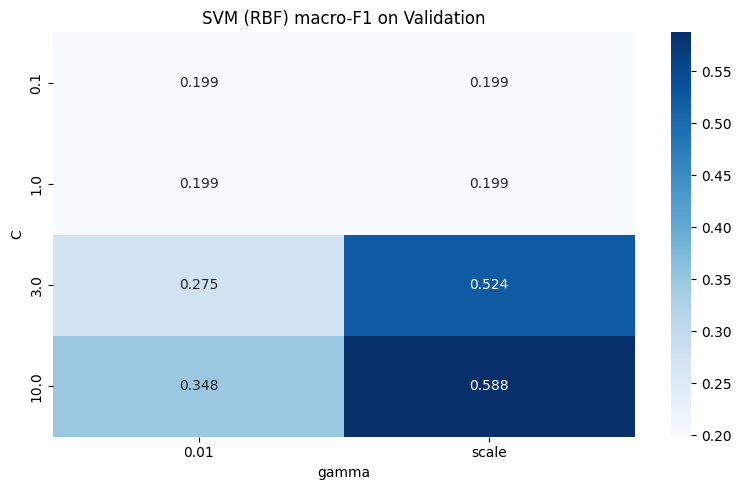

In [ ]:
if svm_df["gamma"].nunique() > 1 and svm_df["C"].nunique() > 1:
  plt.figure(figsize=(8,5))
  pivot = svm_df.pivot(index="C", columns="gamma", values="F1_macro")
  sns.heatmap(pivot, annot=True, fmt=".3f", cmap="Blues")
  plt.title("SVM (RBF) macro-F1 on Validation")
  plt.ylabel("C"); plt.xlabel("gamma")
  plt.tight_layout(); plt.show()
else:
  print("Heatmap skipped (need >= 2 values for both C and gamma).")

Refit the best Train+Val with probabilities (for threshold tuning)

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    average_precision_score, roc_auc_score
)

# Lock in best hyperparams from heatmap
best = svm_df.iloc[0]
best_C, best_gamma = float(best["C"]), best["gamma"]
print(f"chose SVM: C={best_C}, gamma={best_gamma}")

# Train a model on train only, pick gamma on validation

svm_train_only = SVC(kernel="rbf", C=best_C, gamma=best_gamma,
                class_weight="balanced",
                probability=True, shrinking=True, cache_size=2000,
                tol=1e-2, max_iter=5000, random_state=42)
svm_train_only.fit(X_train_s, y_train)

# Choose decision threshold on validation (max-F1)
val_proba_tune = svm_train_only.predict_proba(X_val_s)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, val_proba_tune)
f1_vals = 2*(prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1]+1e-12)
tau = thr[np.argmax(f1_vals)]
print("val proba percentiles (train-only mode):", np.percentile(val_proba_tune, [0,25,50,75,95,99,100]))
print(f"Chosen gamma (max-F1 on validation): {tau:.4f}")

# Refit scaelr on Train+Val and refit SVM with the same hyperparams (probability=True)
# Keep gamma fixed from step 6. Evaluate once on test
X_train_val = pd.concat([X_train, X_val], axis=0, ignore_index=True)
y_train_val = np.concatenate([y_train, y_val])

scaler_final = StandardScaler().fit(X_train_val)
X_train_val_s = scaler_final.transform(X_train_val)
X_test_s_final = scaler_final.transform(X_test)

svm_final = SVC(kernel="rbf",
                C=best_C, gamma=best_gamma,
                class_weight="balanced",
                probability=True, shrinking=True, cache_size=2000,
                tol=1e-12, max_iter=500000, random_state=42)
svm_final.fit(X_train_val_s, y_train_val)

# Test metrics at the chosen threshold + confusion matrix
test_proba = svm_final.predict_proba(X_test_s_final)[:, 1]
yhat = (test_proba >= tau).astype(int)

prec_test = precision_score(y_test, yhat, zero_division=0)
rec_test = recall_score(y_test, yhat, zero_division=0)
f1_test = f1_score(y_test, yhat)
acc_test = accuracy_score(y_test, yhat)

print("\n=== SVM (RBF) Test metrics at τ (max-F1 on validation) ===")
print(f"Precision  : {prec_test:.3f}")
print(f"Recall     : {rec_test:.3f}")
print(f"F1         : {f1_test:.3f}")
print(f"Accuracy   : {acc_test:.3f}")

chose SVM: C=10.0, gamma=scale


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


val proba percentiles (train-only mode): [0.03451296 0.0839011  0.13195332 0.22088893 0.47688129 0.57289716
 0.60532092]
Chosen gamma (max-F1 on validation): 0.0706


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



=== SVM (RBF) Test metrics at τ (max-F1 on validation) ===
Precision  : 0.480
Recall     : 0.929
F1         : 0.633
Accuracy   : 0.733


In [ ]:
# add results to all models summary table
final_results.append({"Model": "SVM", "Accuracy": round(acc_test,2), "Precision": round(prec_test,2), "Recall": round(rec_test,2)})

Confusion Matrix

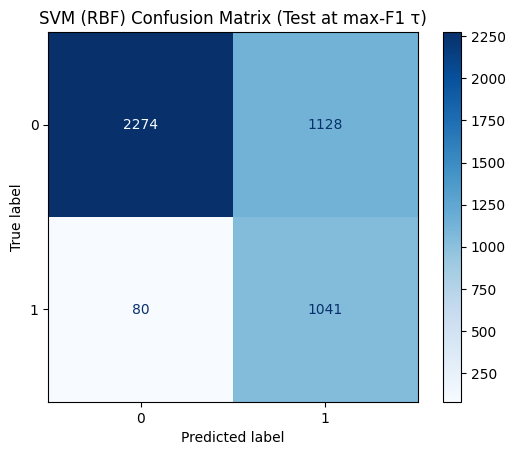

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, yhat)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("SVM (RBF) Confusion Matrix (Test at max-F1 τ)")
plt.show()

Precision-targeted operating point

Chosen τ for Precision>=0.70: 0.5150

== TEST at Precision >= 0.70 threshold ===
Precision  : 0.6257621951219512
Recall     : 0.7323818019625334
F1         : 0.6748869708179203
Accuracy   : 0.8251160734026088


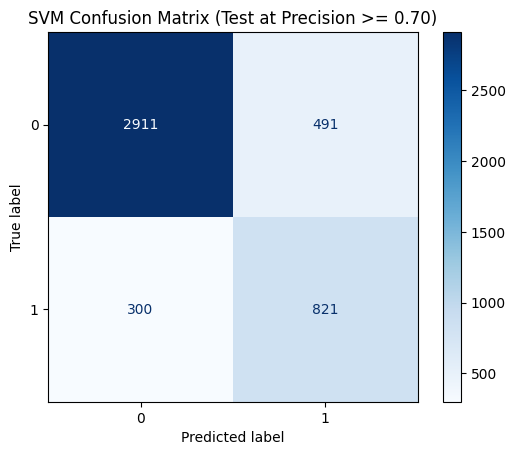

In [ ]:
# Precision-targeted threshold chosen on validation (train-only model)

prec, rec, thr = precision_recall_curve(y_val, val_proba_tune)
target_P = 0.70
mask = (prec[:-1] >= target_P)
tau_p70 = thr[mask.argmax()] if mask.any() else thr[np.argmax(2*(prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1]+1e-12))]
print(f"Chosen τ for Precision>={target_P:.2f}: {tau_p70:.4f}")

# Evaluate on Test at τ_p70
yhat_p70 = (test_proba >= tau_p70).astype(int)
print("\n== TEST at Precision >= 0.70 threshold ===")
print("Precision  :", precision_score(y_test, yhat_p70, zero_division=0))
print("Recall     :", recall_score(y_test, yhat_p70, zero_division=0))
print("F1         :", f1_score(y_test, yhat_p70))
print("Accuracy   :", accuracy_score(y_test, yhat_p70))

cm = confusion_matrix(y_test, yhat_p70)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("SVM Confusion Matrix (Test at Precision >= 0.70)")
plt.show()

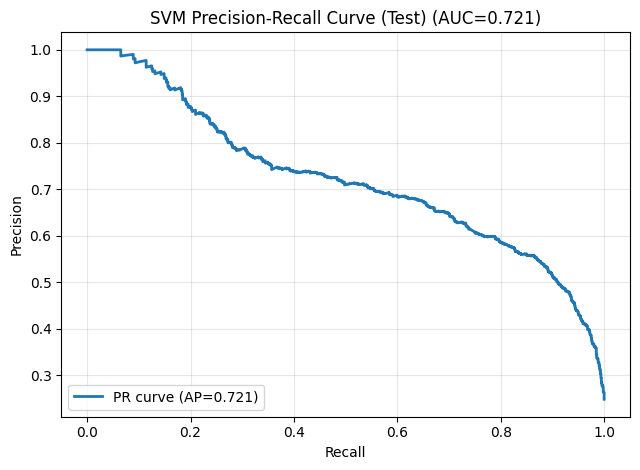

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

y_true = np.asarray(y_test).astype(int).ravel()
y_score = np.asarray(test_proba).astype(float).ravel()

assert y_true.shape[0] == y_score.shape[0], (y_true.shape, y_score.shape)

# PR-curve + AP (PR-AUC)
prec, recall, thr = precision_recall_curve(y_true, y_score)
ap = average_precision_score(y_true, y_score)
pr_auc = auc(recall, prec)

plt.figure(figsize=(6.5, 4.8))
plt.plot(recall, prec, linewidth=2, label=f"PR curve (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"SVM Precision-Recall Curve (Test) (AUC={pr_auc:.3f})")
plt.grid(alpha=0.3)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


Neural Network

preprocessing for neural network




In [ ]:
import numpy as np
import pandas as pd

# Check missing values
df.isna().sum().sort_values(ascending=False).head(10)

# Columns with NaN values
na_cols = ["workclass", "occupation", "native-country"]

# Copy of original for comparison
df_orig = df.copy()

# Drop NaNs
df_clean = df.dropna(subset=na_cols).copy()

# Number of missing values
print("Missing values:", df.shape[0] - df_clean.shape[0])

before, after = len(df), len(df_clean)
print(f"Rows before: {len(df_orig):,} | after drop: {len(df_clean):,} | removed: {len(df_orig)-len(df_clean):,}"
      f"({(len(df_orig)-len(df_clean))/len(df_orig):.2%})")

# Class prvalence before vs after (unweighted)
prev_before = df_orig["target"].mean()
prev_after = df_clean["target"].mean()
print(f"Prevalence y=1 before: {prev_before:.3f} | after: {prev_after:.3f}")

df_clean.head()

Missing values: 3620
Rows before: 48,842 | after drop: 45,222 | removed: 3,620(7.41%)
Prevalence y=1 before: 0.239 | after: 0.248


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class,target,has_capital_gain,has_capital_loss
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K,0,0,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K,0,0,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K,1,0,0
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K,1,1,0
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K,0,0,0


In [ ]:
# Log transformation of columns
cols_to_log = ["capital-gain", "capital-loss"]
df_clean[cols_to_log] = df_clean[cols_to_log].apply(np.log1p)

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoders = {}  # Store encoders for decoding later
categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns

# df_clean.columns
for column in categorical_cols:
    le = LabelEncoder()
    df_clean[column] = le.fit_transform(df_clean[column])  # Convert categorical values to numbers
    label_encoders[column] = le  # Store encoders for later decoding

    # Print the mapping of categorical values to numbers
    print(f"Mapping for '{column}':")
    print(dict(zip(le.classes_, le.transform(le.classes_))))  # Shows the mapping in alphabetical order
    print() # Empty line for better readability


Mapping for 'workclass':
{'Federal-gov': np.int64(0), 'Local-gov': np.int64(1), 'Private': np.int64(2), 'Self-emp-inc': np.int64(3), 'Self-emp-not-inc': np.int64(4), 'State-gov': np.int64(5), 'Without-pay': np.int64(6)}

Mapping for 'education':
{'10th': np.int64(0), '11th': np.int64(1), '12th': np.int64(2), '1st-4th': np.int64(3), '5th-6th': np.int64(4), '7th-8th': np.int64(5), '9th': np.int64(6), 'Assoc-acdm': np.int64(7), 'Assoc-voc': np.int64(8), 'Bachelors': np.int64(9), 'Doctorate': np.int64(10), 'HS-grad': np.int64(11), 'Masters': np.int64(12), 'Preschool': np.int64(13), 'Prof-school': np.int64(14), 'Some-college': np.int64(15)}

Mapping for 'marital-status':
{'Divorced': np.int64(0), 'Married-AF-spouse': np.int64(1), 'Married-civ-spouse': np.int64(2), 'Married-spouse-absent': np.int64(3), 'Never-married': np.int64(4), 'Separated': np.int64(5), 'Widowed': np.int64(6)}

Mapping for 'occupation':
{'Adm-clerical': np.int64(0), 'Armed-Forces': np.int64(1), 'Craft-repair': np.int64(2

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd


# 3) First split: train vs temp (80% / 20%), stratified by label
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# 4) Second split: val vs test (15% / 15% overall), stratified again
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# 5) Class balance in each split
def describe_split(name, y_arr):
    counts = pd.Series(y_arr).value_counts(normalize=True).sort_index()
    print(f"{name:>6s} | n={len(y_arr):5d} | P(y=1)={counts.get(1,0):.3f} | P(y=0)={counts.get(0,0):.3f}")

describe_split("train", y_train)
describe_split("  val", y_val)
describe_split(" test", y_test)

# Baseline PR-AUC you should beat ~ prevalence
prevalence = y.mean()
print(f"\nBaseline PR-AUC (≈ prevalence): {prevalence:.3f}")

 train | n=36177 | P(y=1)=0.248 | P(y=0)=0.752
   val | n= 4522 | P(y=1)=0.248 | P(y=0)=0.752
  test | n= 4523 | P(y=1)=0.248 | P(y=0)=0.752

Baseline PR-AUC (≈ prevalence): 0.248


In [ ]:
# importing necessary libraries
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    average_precision_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
)
from sklearn.utils.class_weight import compute_class_weight


Scaling the numerical features since neural networks are highly sensitive to input scale


In [ ]:
# data preprocessing

# defining the neumeric columns to scale
num_Cols = ['age', 'education-num', 'capital-gain']

scaler = StandardScaler()
X_train[num_Cols] = scaler.fit_transform(X_train[num_Cols])
X_test[num_Cols] = scaler.transform(X_test[num_Cols])

making the data types similar for the nerual netowrk to handle it better

In [ ]:
# converting all inputs and output arrays to float 32

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

#### building the first neural network

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


905/905 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7475 - loss: 0.5489 - val_accuracy: 0.8105 - val_loss: 0.4035
Epoch 2/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8118 - loss: 0.4051 - val_accuracy: 0.8252 - val_loss: 0.3731
Epoch 3/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8205 - loss: 0.3830 - val_accuracy: 0.8257 - val_loss: 0.3711
Epoch 4/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8237 - loss: 0.3692 - val_accuracy: 0.8292 - val_loss: 0.3580
Epoch 5/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8276 - loss: 0.3611 - val_accuracy: 0.8252 - val_loss: 0.3619
Epoch 6/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8305 - loss: 0.3556 - val_accuracy: 0.8292 - val_loss: 0.3551
Epoch 7/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8314 - loss: 0.3577 - val_accuracy: 0.8307 - val_loss: 0.3530
Epoch 8/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8369 - loss: 0.3465 - val_accuracy: 0.8290 - val_

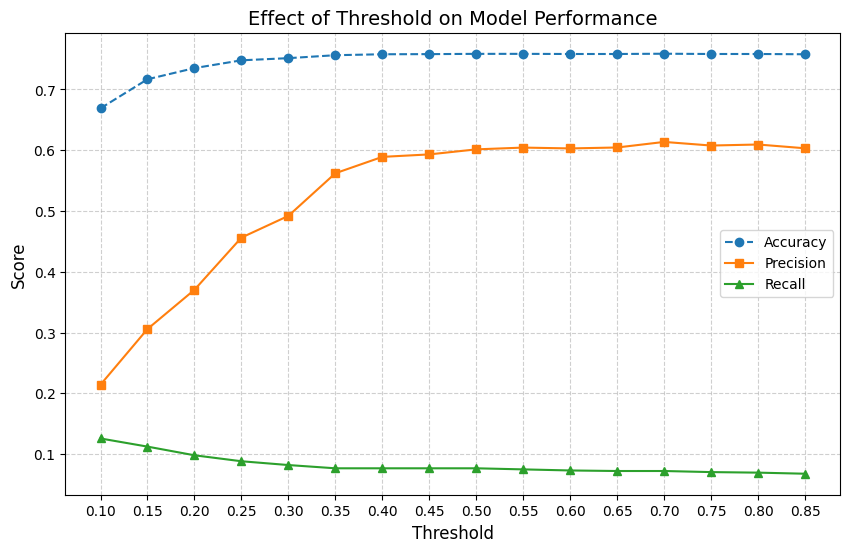

In [ ]:
4# Neural Network Model
input_dim = X_train.shape[1]

# Create a sequential neural network model
# Architecture:
# - 3 hidden layers (128, 64, 32 neurons)
# - ReLU activation for nonlinearity
# - Dropout for regularization (reduces overfitting)
# - Output layer with sigmoid activation for binary classificatio
model = Sequential([
    Dense(128, activation='relu', input_dim=input_dim),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compute class weights to handle class imbalance
# helps give importance to minority class
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Compile the model with:
# - Adam optimizer (adaptive learning rate)
# - Binary crossentropy loss for two-class problems
# - Track accuracy during training
model.compile(
    optimizer=Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']  # accuracy is built-in
)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate on Test Set
# Define range of thresholds to test
thresholds = np.arange(0.1, 0.9, 0.05)

# Prepare empty lists to store metrics for each threshold
accuracies, precisions, recalls = [], [], []

# Predict probabilities for validation data
y_pred_prob = model.predict(X_val).ravel()

# Loop through each threshold and compute evaluation metrics
for t in thresholds:
    y_pred = (y_pred_prob >= t).astype(int)
    accuracies.append(accuracy_score(y_val, y_pred))
    precisions.append(precision_score(y_val, y_pred))
    recalls.append(recall_score(y_val, y_pred))

# Ploting hwo each metrics changes along with the threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, label='Accuracy', marker='o', linestyle='--')
plt.plot(thresholds, precisions, label='Precision', marker='s', linestyle='-')
plt.plot(thresholds, recalls, label='Recall', marker='^', linestyle='-')

plt.title('Effect of Threshold on Model Performance', fontsize=14)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(thresholds)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Used different model architecture by adding and removing layers and playing around with layer density, tried differnt learnign rate as well and have choosen this one since it provided the highest accuracy and precision score among the others.

Evaluation using different thresholds revealed that using a threshold of 0.5 gave us the best true positives and true negatives values.

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold: 0.5
Accuracy:  0.8426
Precision: 0.7547
Recall:    0.5406
PR-AUC:    0.7532


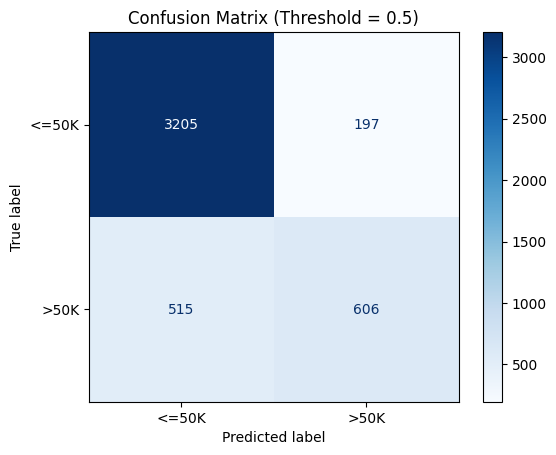

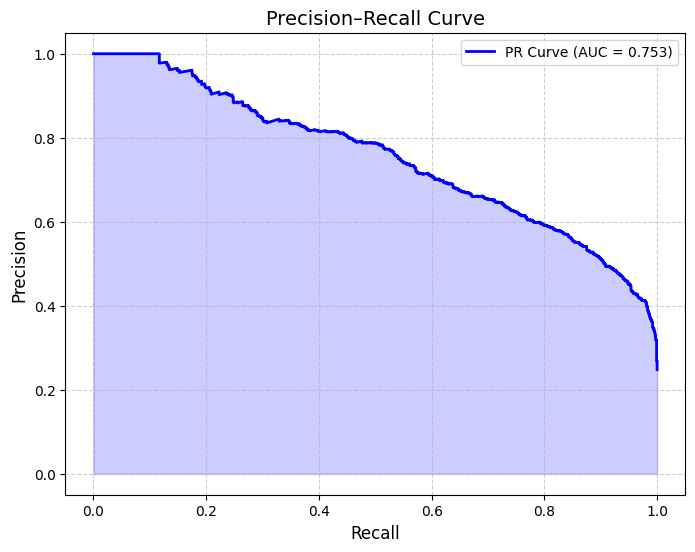

In [ ]:
# Final Evaluation of Neural network model

# Predicting the probabilities on the test set
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
pr_auc = average_precision_score(y_test, y_pred_prob)

# Add results to all models summary table
final_results.append({"Model": "Light weight Neural Network", "Accuracy": round(acc,2), "Precision": round(prec,2), "Recall": round(rec,2)})


# printing the key metrics
print(f"Threshold: {0.5}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"PR-AUC:    {pr_auc:.4f}")

# Generate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix (Threshold = {0.5})')
plt.show()

# Plot Precision–Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.3f})', color='blue', linewidth=2)
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision–Recall Curve', fontsize=14)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

####The second Neural Network model

For the second neural network the same pre processing steps as the inital neural network was used

In [ ]:
# Neural Network Model
input_dim = X_train.shape[1]

# Create a sequential neural network model
# Architecture:
# - 3 hidden layers (128, 64, 32 neurons)
# - ReLU activation for nonlinearity
# - Dropout for regularization (reduces overfitting)
# - Output layer with sigmoid activation for binary classificatio
model = Sequential([
    Dense(512, activation='tanh', input_dim=input_dim),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='tanh'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='tanh'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='tanh'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])


# Compute class weights to handle class imbalance
# helps give importance to minority class
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Compile the model with:
# - Adam optimizer (adaptive learning rate)
# - Binary crossentropy loss for two-class problems
# - Track accuracy during training
model.compile(
    optimizer=Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']  # accuracy is built-in
)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate on Test Set
# Define range of thresholds to test
thresholds = np.arange(0.1, 0.9, 0.05)

# Prepare empty lists to store metrics for each threshold
accuracies, precisions, recalls = [], [], []

# Predict probabilities for test data
y_pred_prob = model.predict(X_val).ravel()

# Loop through each threshold and compute evaluation metrics
for t in thresholds:
    y_pred = (y_pred_prob >= t).astype(int)
    accuracies.append(accuracy_score(y_val, y_pred))
    precisions.append(precision_score(y_val, y_pred))
    recalls.append(recall_score(y_val, y_pred))

# Ploting hwo each metrics changes along with the threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, label='Accuracy', marker='o', linestyle='--')
plt.plot(thresholds, precisions, label='Precision', marker='s', linestyle='-')
plt.plot(thresholds, recalls, label='Recall', marker='^', linestyle='-')

plt.title('Effect of Threshold on Model Performance', fontsize=14)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(thresholds)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7587 - loss: 0.4999 - val_accuracy: 0.8201 - val_loss: 0.3819
Epoch 2/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8146 - loss: 0.3918 - val_accuracy: 0.8227 - val_loss: 0.3741
Epoch 3/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8223 - loss: 0.3773 - val_accuracy: 0.8206 - val_loss: 0.3676
Epoch 4/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8207 - loss: 0.3720 - val_accuracy: 0.8228 - val_loss: 0.3679
Epoch 5/50
130/905 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8288 - loss: 0.3725

Evaluating on the test set

In [ ]:
# Final Evaluation of Neural network model

# Predicting the probabilities again
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
pr_auc = average_precision_score(y_test, y_pred_prob)

# Add results to all models summary table
final_results.append({"Model": "Dense Neural Network", "Accuracy": round(acc,2), "Precision": round(prec,2), "Recall": round(rec,2)})

# printing the key metrics
print(f"Threshold: {0.5}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"PR-AUC:    {pr_auc:.4f}")

# Generate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix (Threshold = {0.5})')
plt.show()

# Plot Precision–Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.3f})', color='blue', linewidth=2)
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision–Recall Curve', fontsize=14)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
# Summary of results
import pandas as pd

# Convert the results into a DataFrame for better readability
results_df = pd.DataFrame(final_results)

# Print the performance results of all models
print("Model Comparison Results:")
print(results_df.to_string(index=False))
